In [18]:
import os, glob
import numpy as np
import soundfile
import librosa
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

In [19]:
print(librosa.__version__)
print(soundfile.__version__)
print(sklearn.__version__)

0.10.2.post1
0.13.1
1.6.1


In [23]:
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split

# Emotions mapping
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Only load selected emotions
observed_emotions = ['calm', 'happy', 'fearful', 'disgust']

# Feature extractor 


def extract_feature(file_name, mfcc=True, chroma=True, mel=True, augment=False):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate

        if augment:
            X = librosa.effects.pitch_shift(X, sr=sample_rate, n_steps=np.random.uniform(-2, 2))
            X = librosa.effects.time_stretch(X, rate=np.random.uniform(0.8, 1.2))

        stft = np.abs(librosa.stft(X)) if chroma else None
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma_features = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma_features))
        if mel:
            mel_features = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel_features))
    return result
# Loader

# Modify load_data to apply augmentation only to training data
def load_data(test_size=0.25):
    x, y = [], []

    # Load original features (no augmentation)
    for file in glob.glob("emotion_dataset/emotion-dataset/Actor_*/*"):
        file_name = os.path.basename(file)
        emotion = emotions.get(file_name.split("-")[2])
        if emotion not in observed_emotions:
            continue
        feature = extract_feature(file, mfcc=True, chroma=True, mel=True, augment=False)
        x.append(feature)
        y.append(emotion)

    # Split data
    x_train, x_test, y_train, y_test = train_test_split(np.array(x), y, test_size=test_size, random_state=9)

    # Augment training data only
    for file in glob.glob("emotion_dataset/emotion-dataset/Actor_*/*"):
        file_name = os.path.basename(file)
        emotion = emotions.get(file_name.split("-")[2])
        if emotion not in observed_emotions:
            continue
        for _ in range(1):  # Apply 3 augmentations per sample
            feature = extract_feature(file, mfcc=True, chroma=True, mel=True, augment=True)
            x_train = np.vstack([x_train, feature])
            y_train.append(emotion)

    return x_train, x_test, y_train, y_test






In [24]:
x_train, x_test, y_train, y_test = load_data()
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Evaluate model with Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = MLPClassifier(
   hidden_layer_sizes=(1024, 512, 256, 128),
    activation='relu',
    solver='adam',
    alpha=0.00005,
    batch_size=32,
    learning_rate_init=0.001,
    max_iter=1200,
    random_state=42,
    verbose=True
)

scores = cross_val_score(model, x_train, y_train, cv=skf, scoring='accuracy')
print(f"Cross-Validation Accuracy: {np.mean(scores) * 100:.2f}% ± {np.std(scores) * 100:.2f}%")


print(f"Training samples: {x_train.shape[0]}, Testing samples: {x_test.shape[0]}")
print(f"Features extracted: {x_train.shape[1]}")

Iteration 1, loss = 1.18773649
Iteration 2, loss = 0.83574860
Iteration 3, loss = 0.66827573
Iteration 4, loss = 0.47899580
Iteration 5, loss = 0.48962604
Iteration 6, loss = 0.31996905
Iteration 7, loss = 0.23864308
Iteration 8, loss = 0.22950315
Iteration 9, loss = 0.21185486
Iteration 10, loss = 0.31673533
Iteration 11, loss = 0.10989777
Iteration 12, loss = 0.07773484
Iteration 13, loss = 0.05149056
Iteration 14, loss = 0.03592064
Iteration 15, loss = 0.02819118
Iteration 16, loss = 0.15491344
Iteration 17, loss = 0.11815677
Iteration 18, loss = 0.12967837
Iteration 19, loss = 0.05371481
Iteration 20, loss = 0.01080912
Iteration 21, loss = 0.00501262
Iteration 22, loss = 0.00362004
Iteration 23, loss = 0.00374935
Iteration 24, loss = 0.00221299
Iteration 25, loss = 0.00173010
Iteration 26, loss = 0.00166321
Iteration 27, loss = 0.00162363
Iteration 28, loss = 0.00158997
Iteration 29, loss = 0.00156175
Iteration 30, loss = 0.00154187
Iteration 31, loss = 0.00152736
Iteration 32, los

In [25]:
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
train_acc = model.score(x_train, y_train)
test_acc = accuracy_score(y_test, y_pred)

from sklearn.metrics import classification_report

print(f"\nTraining Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Iteration 1, loss = 1.11200815
Iteration 2, loss = 0.80360589
Iteration 3, loss = 0.62519370
Iteration 4, loss = 0.51625280
Iteration 5, loss = 0.46726155
Iteration 6, loss = 0.45015505
Iteration 7, loss = 0.24363200
Iteration 8, loss = 0.19397671
Iteration 9, loss = 0.14963185
Iteration 10, loss = 0.11590632
Iteration 11, loss = 0.16971945
Iteration 12, loss = 0.08122653
Iteration 13, loss = 0.05399648
Iteration 14, loss = 0.02709548
Iteration 15, loss = 0.00829867
Iteration 16, loss = 0.00298743
Iteration 17, loss = 0.00218580
Iteration 18, loss = 0.00200363
Iteration 19, loss = 0.00188494
Iteration 20, loss = 0.00180376
Iteration 21, loss = 0.00174697
Iteration 22, loss = 0.00170092
Iteration 23, loss = 0.00166767
Iteration 24, loss = 0.00163693
Iteration 25, loss = 0.00161276
Iteration 26, loss = 0.00159314
Iteration 27, loss = 0.00157476
Iteration 28, loss = 0.00155987
Iteration 29, loss = 0.00154655
Iteration 30, loss = 0.00153413
Training loss did not improve more than tol=0.000

In [26]:
y_pred[:10]

array([3, 0, 3, 3, 1, 0, 3, 2, 1, 1], dtype=int64)

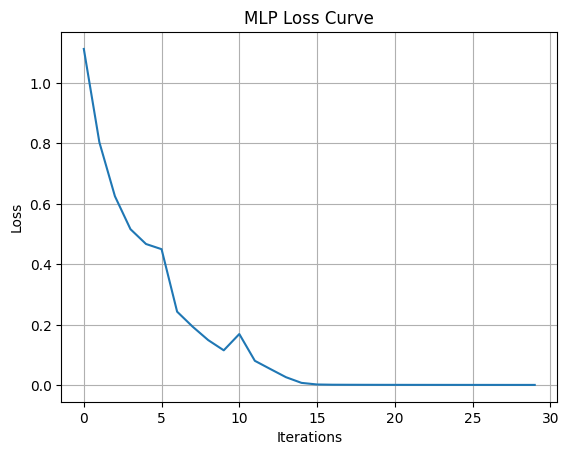

In [27]:
plt.plot(model.loss_curve_)
plt.title("MLP Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [28]:
import pickle

with open("emotion_classification-model.pkl", "wb") as f:
    pickle.dump(model, f)


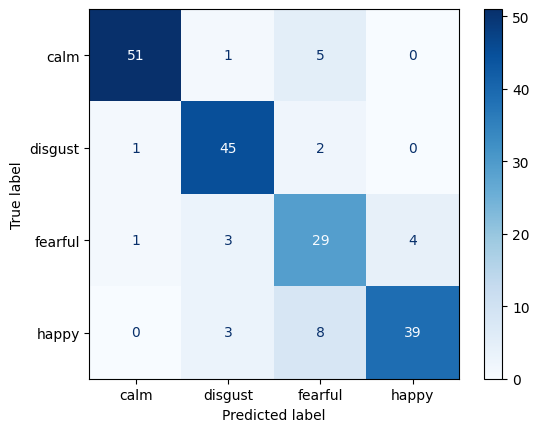

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.show()


In [30]:
plt.plot(model.loss_curve_)
plt.title("MLP Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("loss_curve.png")  # Save instead of show
plt.close()


In [31]:
with open("model_metrics.txt", "w") as f:
    f.write(f"Training Accuracy: {train_acc * 100:.2f}%\n")
    f.write(f"Test Accuracy: {test_acc * 100:.2f}%\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=le.classes_))


In [32]:
# Save model, scaler, and label encoder
import pickle
with open("emotion_classification-model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
